# **Install**

In [ ]:
!pip install flair seqeval pytorch-crf sklearn-crfsuite --quiet

In [ ]:
!pip install --upgrade flair

In [ ]:
!pip install flair[word-embeddings]

# **Import Dataset and Libraries**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# 1. Baca dataset
file_path = "/kaggle/input/nerskill/NERSkill.Id.txt"
df = pd.read_csv(file_path, delimiter="\t", names=["Sentence #", "Word", "Tag"], skiprows=1)

# Mengisi nilai kosong di kolom "Sentence #"
df["Sentence #"] = df["Sentence #"].ffill()  # Perbaikan FutureWarning

# Grupkan dataset berdasarkan "Sentence #"
sentences = (
    df.groupby("Sentence #", group_keys=False)  # Hindari DeprecationWarning
    .apply(lambda s: list(zip(s["Word"], s["Tag"])))
    .tolist()
)

# Pisahkan data menjadi training (70%), validation (20%), dan testing (10%)
train_sentences, temp_sentences = train_test_split(sentences, test_size=0.3, random_state=42)
val_sentences, test_sentences = train_test_split(temp_sentences, test_size=1/3, random_state=42)

<ipython-input-11-f32273d4666c>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda s: list(zip(s["Word"], s["Tag"])))


# **SVM**

## **DictVectorizer**

In [ ]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.svm import LinearSVC
from sklearn.preprocessing import LabelEncoder

In [ ]:
def word_features(sent, i):
    """Extract features from word in sentences"""
    word = sent[i][0]

    features = {
        'bias': 1.0,
        'word.lower()': word.lower(),
        'word[-3:]': word[-3:],
        'word.isupper()': word.isupper(),
        'word.istitle()': word.istitle(),
        'word.isdigit()': word.isdigit(),
    }

    # Contextual features
    if i > 0:
        prev_word = sent[i-1][0]
        features.update({
            '-1:word.lower()': prev_word.lower(),
            '-1:word.istitle()': prev_word.istitle(),
            '-1:word.isupper()': prev_word.isupper(),
        })
    else:
        features['BOS'] = True  # Beginning of sentence

    if i < len(sent)-1:
        next_word = sent[i+1][0]
        features.update({
            '+1:word.lower()': next_word.lower(),
            '+1:word.istitle()': next_word.istitle(),
            '+1:word.isupper()': next_word.isupper(),
        })
    else:
        features['EOS'] = True  # End of sentence

    return features

In [ ]:
def prepare_data(sentences):
    X = []
    y = []
    for sent in sentences:
        for i in range(len(sent)):
            features = word_features(sent, i)
            X.append(features)
            y.append(sent[i][1])
    return X, y

In [ ]:
X_train, y_train = prepare_data(train_sentences)

vectorizer = DictVectorizer(sparse=False)
X_train_vec = vectorizer.fit_transform(X_train)

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

In [ ]:
svm = LinearSVC(loss='squared_hinge', C=1.0, max_iter=1000)
svm.fit(X_train_vec, y_train_enc)

LinearSVC()

In [ ]:
def evaluate_model(sentences):
    X, y = prepare_data(sentences)
    X_vec = vectorizer.transform(X)
    y_enc = le.transform(y)
    preds = svm.predict(X_vec)
    return classification_report(y_enc, preds, target_names=le.classes_)

print("Validation Results:")
print(evaluate_model(val_sentences))

Validation Results:
              precision    recall  f1-score   support

    B-HSkill       0.70      0.62      0.66      3356
    B-SSkill       0.81      0.84      0.82      2109
      B-Tech       0.88      0.88      0.88      3511
    I-HSkill       0.64      0.59      0.62      2328
    I-SSkill       0.78      0.66      0.71       787
      I-Tech       0.73      0.71      0.72       853
           O       0.96      0.97      0.97     71180

    accuracy                           0.93     84124
   macro avg       0.78      0.75      0.77     84124
weighted avg       0.93      0.93      0.93     84124



In [ ]:
from sklearn.metrics import classification_report
from seqeval.metrics import classification_report as seqeval_report
from seqeval.metrics import accuracy_score, f1_score

def evaluate_ner(model, sentences, vectorizer, le):
    """
    Proper NER evaluation that:
    1. Maintains sentence structure
    2. Respects BIO/IOB tagging scheme
    3. Reports entity-level metrics (not just token-level)
    """
    true_tags = []
    pred_tags = []

    for sent in sentences:
        # Get true tags for the sentence
        sent_true_tags = [tag for word, tag in sent]
        true_tags.append(sent_true_tags)

        # Predict tags for each word in sentence
        sent_pred_tags = []
        for i in range(len(sent)):
            features = word_features(sent, i)
            X_vec = vectorizer.transform(features)
            pred = model.predict(X_vec)[0]
            sent_pred_tags.append(le.inverse_transform([pred])[0])
        pred_tags.append(sent_pred_tags)

    # Token-level classification report (sklearn)
    print("Token-Level Classification Report:")
    print(classification_report(
        [tag for sent in true_tags for tag in sent],
        [tag for sent in pred_tags for tag in sent],
        target_names=le.classes_
    ))

    # Sequence-level evaluation (seqeval)
    print("\nEntity-Level Classification Report:")
    print(seqeval_report(true_tags, pred_tags))

    return true_tags, pred_tags

# Usage
true_tags, pred_tags = evaluate_ner(svm, test_sentences, vectorizer, le)

Token-Level Classification Report:
              precision    recall  f1-score   support

    B-HSkill       0.72      0.61      0.66      1751
    B-SSkill       0.80      0.83      0.81      1116
      B-Tech       0.87      0.87      0.87      1538
    I-HSkill       0.66      0.58      0.62      1159
    I-SSkill       0.76      0.63      0.69       377
      I-Tech       0.74      0.73      0.74       394
           O       0.96      0.97      0.96     34697

    accuracy                           0.93     41032
   macro avg       0.79      0.75      0.76     41032
weighted avg       0.93      0.93      0.93     41032


Entity-Level Classification Report:
              precision    recall  f1-score   support

      HSkill       0.54      0.54      0.54      1763
      SSkill       0.74      0.79      0.76      1132
        Tech       0.80      0.82      0.81      1540

   micro avg       0.69      0.70      0.69      4435
   macro avg       0.70      0.71      0.70      4435
weigh

=== Token-Level Analysis ===


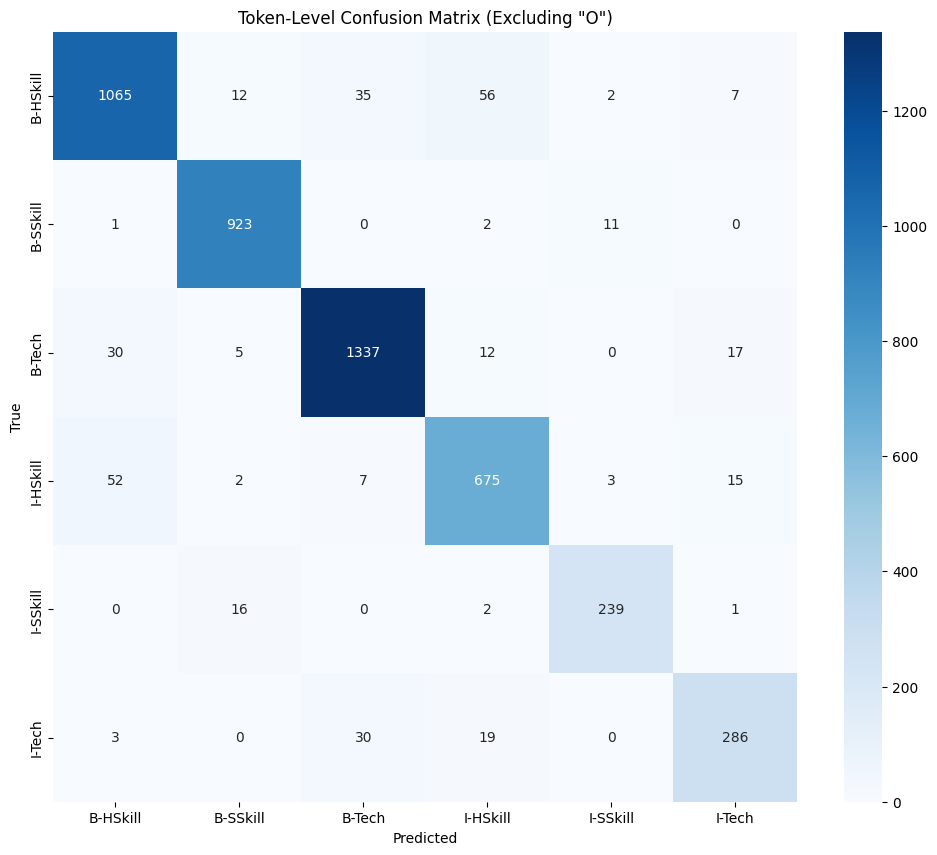

In [ ]:
from sklearn.metrics import confusion_matrix
from seqeval.metrics import classification_report
from collections import defaultdict

def token_level_confusion(true_tags, pred_tags, le):
    # Flatten tags and exclude 'O'
    y_true = [tag for sent in true_tags for tag in sent]
    y_pred = [tag for sent in pred_tags for tag in sent]

    # Get labels excluding 'O'
    labels = [label for label in le.classes_ if label != 'O']

    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=labels)

    # Plot
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Token-Level Confusion Matrix (Excluding "O")')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Run all analyses
print("=== Token-Level Analysis ===")
token_level_confusion(true_tags, pred_tags, le)

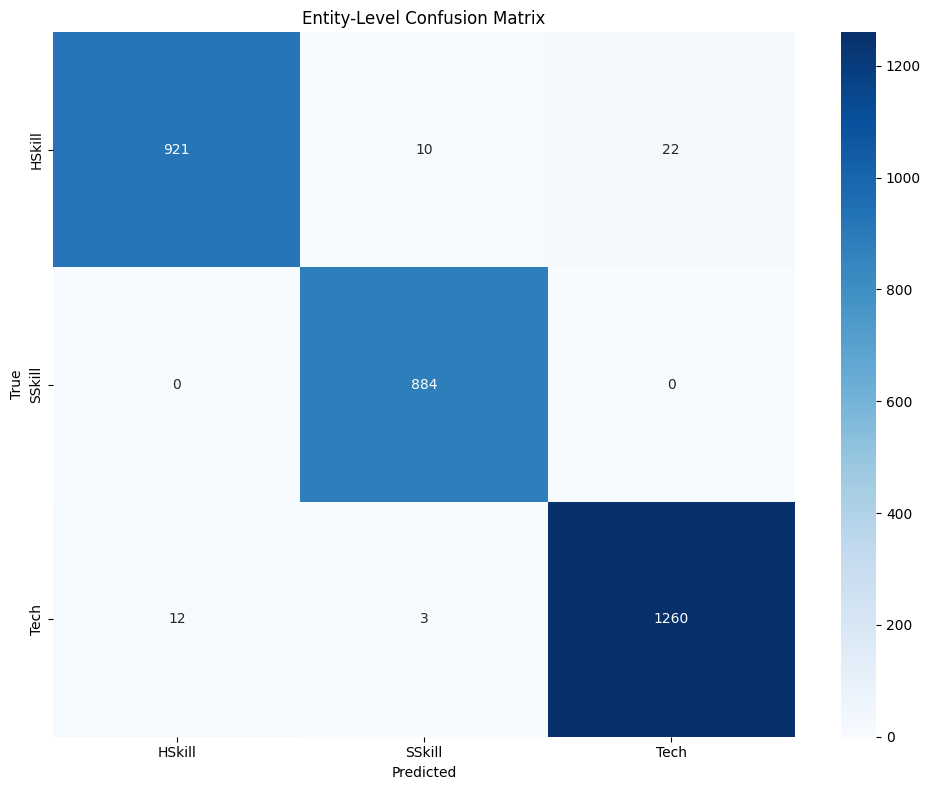

In [ ]:
def entity_level_confusion_matrix(true_tags, pred_tags):
    # Get all entity types (excluding 'O')
    entity_types = set()
    for sent_true, sent_pred in zip(true_tags, pred_tags):
        for tag in sent_true + sent_pred:
            if tag != 'O':
                entity_types.add(tag.split('-')[1] if '-' in tag else tag)

    # Initialize matrix
    entity_types = sorted(entity_types)
    cm = np.zeros((len(entity_types), len(entity_types)), dtype=int)

    # Count errors
    for sent_true, sent_pred in zip(true_tags, pred_tags):
        true_entities = get_entities(sent_true)
        pred_entities = get_entities(sent_pred)

        for true_entity in true_entities:
            true_type = true_entity[0]
            if true_type not in entity_types:
                continue

            found = False
            for pred_entity in pred_entities:
                if true_entity[1:] == pred_entity[1:]:  # Same span
                    pred_type = pred_entity[0]
                    if pred_type in entity_types:
                        cm[entity_types.index(true_type),
                           entity_types.index(pred_type)] += 1
                    found = True
                    break

            if not found:  # False Negative
                cm[entity_types.index(true_type),
                   entity_types.index(true_type)] += 0  # FN not shown in diagonal

    return cm, entity_types

# Helper function to extract entities (from seqeval)
def get_entities(seq):
    """Convert BIO tags to entity list"""
    entities = []
    entity = None
    for i, tag in enumerate(seq):
        if tag.startswith('B-'):
            if entity is not None:
                entities.append(entity)
            entity = [tag[2:], i, i]  # [type, start, end]
        elif tag.startswith('I-'):
            if entity is not None and tag[2:] == entity[0]:
                entity[2] = i
            else:
                if entity is not None:
                    entities.append(entity)
                entity = None
        else:
            if entity is not None:
                entities.append(entity)
            entity = None
    if entity is not None:
        entities.append(entity)
    return entities

# Generate and plot
entity_cm, entity_labels = entity_level_confusion_matrix(true_tags, pred_tags)

plt.figure(figsize=(10, 8))
sns.heatmap(entity_cm, annot=True, fmt='d',
            xticklabels=entity_labels,
            yticklabels=entity_labels,
            cmap='Blues')
plt.title('Entity-Level Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [ ]:
def token_comparison(true_tags, pred_tags, test_sentences):
    correct = []
    incorrect = []

    for sent, true, pred in zip(test_sentences, true_tags, pred_tags):
        for (word, _), t, p in zip(sent, true, pred):
            if t == 'O' and p == 'O':
                continue

            if t == p:
                correct.append((word, t))
            else:
                incorrect.append((word, t, p))

    # Convert to DataFrames
    correct_df = pd.DataFrame(correct, columns=['Word', 'Tag'])
    incorrect_df = pd.DataFrame(incorrect, columns=['Word', 'True', 'Predicted'])

    # Analysis
    print("\n=== Token-Level Correct Predictions (Top 20) ===")
    print(correct_df.value_counts().head(20))

    print("\n=== Token-Level Incorrect Predictions (Top 20) ===")
    print(incorrect_df.value_counts().head(20))

    return correct_df, incorrect_df

def entity_level_comparison(true_tags, pred_tags, test_sentences):
    def extract_entities(tags, words):
        entities = []
        current = None

        for i, (tag, word) in enumerate(zip(tags, words)):
            if tag.startswith('B-'):
                if current is not None:
                    entities.append(current)
                current = {'type': tag[2:], 'start': i, 'text': [word]}
            elif tag.startswith('I-'):
                if current is not None and tag[2:] == current['type']:
                    current['text'].append(word)
            else:
                if current is not None:
                    entities.append(current)
                    current = None
        if current is not None:
            entities.append(current)

        return [f"{' '.join(e['text'])} [{e['type']}]" for e in entities]

    correct = []
    incorrect = []
    missed = []
    spurious = []

    for sent, true, pred in zip(test_sentences, true_tags, pred_tags):
        words = [w for w, _ in sent]
        true_ents = extract_entities(true, words)
        pred_ents = extract_entities(pred, words)

        # Correct entities
        for ent in set(true_ents) & set(pred_ents):
            correct.append(ent)

        # Incorrect cases
        for ent in set(true_ents) - set(pred_ents):
            incorrect.append((ent, "MISSED"))
            missed.append(ent)

        for ent in set(pred_ents) - set(true_ents):
            incorrect.append((ent, "SPURIOUS"))
            spurious.append(ent)

    # Analysis
    print("\n=== Entity-Level Correct Predictions (Top 20) ===")
    print(pd.Series(correct).value_counts().head(20))

    print("\n=== Entity-Level Errors ===")
    print(f"Missed entities: {len(missed)}")
    print(f"Spurious entities: {len(spurious)}")

    print("\n=== Entity-Level Error Examples (Top 20) ===")
    error_df = pd.DataFrame(incorrect, columns=['Entity', 'Error'])
    print(error_df.value_counts().head(20))

    return correct, incorrect

correct_tokens, incorrect_tokens = token_comparison(true_tags, pred_tags, test_sentences)

print("\n=== Entity-Level Analysis ===")
correct_ents, incorrect_ents = entity_level_comparison(true_tags, pred_tags, test_sentences)


=== Token-Level Correct Predictions (Top 20) ===
Word         Tag     
PHP          B-Tech      89
tim          B-SSkill    66
komunikasi   B-SSkill    64
HTML         B-Tech      54
pemrograman  B-HSkill    54
jaringan     B-HSkill    48
lunak        I-HSkill    47
perangkat    B-HSkill    46
CSS          B-Tech      45
MySQL        B-Tech      43
Java         B-Tech      41
Inggris      I-SSkill    37
software     B-HSkill    36
Software     B-HSkill    35
tekanan      I-SSkill    33
individu     B-SSkill    32
Linux        B-Tech      32
database     B-HSkill    31
Javascript   B-Tech      30
Microsoft    B-Tech      30
Name: count, dtype: int64

=== Token-Level Incorrect Predictions (Top 20) ===
Word          True      Predicted
IT            B-HSkill  O            34
tim           O         B-SSkill     33
sistem        B-HSkill  O            16
pengembangan  B-HSkill  O            15
komputer      I-HSkill  O            13
lunak         O         I-HSkill     13
data          O 